In [1]:
import numpy as np
from tqdm import tqdm,trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST
import torchvision
import matplotlib.pyplot as plt
np.random.seed(0)
torch.manual_seed(0)

In [2]:
batch_size = 128

In [3]:
transform = ToTensor()
train_set = MNIST(root='./../datasets',train=True,download=True,transform=transform)
test_set = MNIST(root='./../datasets',train=False,download=True,transform=transform)

train_loader = DataLoader(train_set, shuffle=True,batch_size=batch_size)
test_loader = DataLoader(test_set, shuffle=True,batch_size=batch_size)


In [4]:
print(f'Size of train_dataset = {len(train_set)}')
print(f'Size of test_dataset = {len(test_set)}')

Size of train_dataset = 60000
Size of test_dataset = 10000


In [5]:
img,label = next(iter(train_loader))

In [6]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)),cmap='gray')
    plt.show()

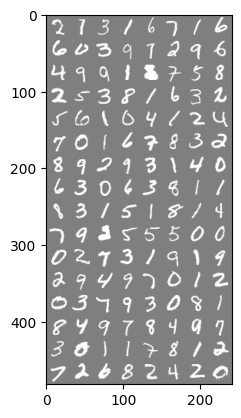

In [7]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

In [8]:
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")


Using device:  cuda (NVIDIA GeForce GTX 1650)


In [9]:
import math

def get_patches(images,patch_size = 4):

    n,c,h,w = images.shape
    n_patches = int(math.sqrt((c*h*w)/(patch_size**2)))
    patches = torch.zeros(n,n_patches**2,patch_size**2)
    for idx,image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:,i*patch_size:(i+1)*patch_size,j*patch_size:(j+1)*patch_size]
                patches[idx,i*n_patches+j] = patch.flatten()


    return patches.to(device)                     

In [20]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result.to(device)

# plt.imshow(get_positional_embeddings(100, 300), cmap="hot", interpolation="nearest")
# plt.show()

In [11]:
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

class MyVitBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyVitBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

In [24]:
model = MyVitBlock(hidden_d=8, n_heads=2).to(device)

x = torch.randn(7, 50, 8).to(device)  # Dummy sequences
print(model(x).shape)   

torch.Size([7, 50, 8])


In [31]:
class VIT(nn.Module):
    def __init__(self,patch_size = 4,n_blocks = 2,embed_dim = 8,n_heads = 2,out_d = 10 ):
        super(VIT,self).__init__()

        self.patch_size = patch_size
        self.n_patches = 7
        self.input_dim = 16
        self.embed_dim = embed_dim
        self.linear_embeddings = nn.Linear(self.input_dim,self.embed_dim)
                

        self.class_token = nn.Parameter(torch.rand(1, self.embed_dim)).to(device)

        self.register_buffer('positional_embeddings', get_positional_embeddings(self.n_patches ** 2 + 1, self.embed_dim), persistent=False)


        # self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches ** 2 + 1, self.embed_dim)))
        # self.pos_embed.requires_grad = False
        # self.mhsa = nn.MultiheadAttention(embed_dim = self.embed_dim,num_heads =2)
        # self.ln = nn.LayerNoa
        
        self.blocks = nn.ModuleList([MyVitBlock(self.embed_dim, n_heads) for _ in range(n_blocks)])

        self.mlp = nn.Sequential(
            nn.Linear(self.embed_dim, out_d),
            nn.Softmax(dim=-1)
        )

    def forward(self,images):
        n,c,h,w = images.shape
        print('fsf')
        patches = get_patches(images,patch_size = self.patch_size)
        print('fs')
        tokens = self.linear_embeddings(patches)
        print(self.positional_embeddings.shape)
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)
 

        for block in self.blocks:
            out = block(out)

        out = out[:, 0]
        
        return self.mlp(out)


In [32]:
model = VIT( patch_size=4, n_blocks=2, embed_dim=8, n_heads=2, out_d=10).to(device)
# model = VIT()

x = torch.randn(7, 1, 28, 28).to(device) # Dummy images
print(model(x).shape) # torch.Size([7, 49, 16])

fsf
fs


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [14]:
N_EPOCHS = 5
LR = 0.005

optimizer = Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

model = VIT(patch_size=4, n_blocks=2, embed_dim=8, n_heads=2, out_d=10).to(device)

In [ ]:
model = model.to(device)

In [15]:
for epoch in trange(N_EPOCHS, desc="Training"):
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
        x, y = batch
        x, y = x.to(device), y.to(device)
        print(x)
        print(y)
        y_hat = model(x)
        print(y_hat)
        loss = criterion(y_hat, y)

        train_loss += loss.detach().cpu().item() / len(train_loader)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

Training:   0%|          | 0/5 [00:00<?, ?it/s]

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

Training:   0%|          | 0/5 [00:01<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [ ]:
# Test loop
with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    for batch in tqdm(test_loader, desc="Testing"):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        test_loss += loss.detach().cpu().item() / len(test_loader)

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")